## Import basic packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import tejapi
tejapi.ApiConfig.api_key = 'Your Key'
tejapi.ApiConfig.ignoretz = True


Bad key The font.family property has five values in file /Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 211 ('The font.family property has five values:')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key The font.family property has five values in file /Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc, line 211 ('The font.family property has five values:')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution


## Load data & Preprocessing

In [2]:
data = tejapi.get('TWN/APRCD', # 公司交易資料-收盤價
                  coid= '0050', # 台灣50
                  mdate={'gte': '2003-01-01', 'lte':'2021-12-31'},
                  opts={'columns': ['mdate', 'close_d', 'roi']},
                  chinese_column_name=True,
                  paginate=True)
data['年月日'] = pd.to_datetime(data['年月日'])
data = data.set_index('年月日')
data = data.rename(columns = {'收盤價(元)':'收盤價', '報酬率％':'日報酬率(%)'})
data

,收盤價,日報酬率(%)
年月日,,
2003-06-30,37.08,0.2704
2003-07-01,38.05,2.6160
2003-07-02,38.69,1.6820
2003-07-03,39.00,0.8012
2003-07-04,39.26,0.6667
...,...,...
2021-12-24,143.05,0.2804
2021-12-27,144.15,0.7690
2021-12-28,145.30,0.7978


In [3]:
train_date = data.index.get_level_values('年月日') <= '2020-12-31'
train_data = data[train_date].drop(columns = ['收盤價'])
test_data = data[~train_date]

## ARMA

In [4]:
import statsmodels.api as sm

sm.tsa.stattools.arma_order_select_ic(train_data, ic=["aic", "bic"])

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

{'aic':               0             1             2
 0  14226.906706  14227.321283  14227.900929
 1  14227.265956  14219.250184  14229.774573
 2  14227.939920  14229.156037  14214.877848
 3  14229.450540  14223.929779  14219.608347
 4  14225.725645  14220.976704  14220.782924,
 'bic':               0             1             2
 0  14239.654737  14246.443329  14253.396990
 1  14246.388002  14244.746246  14261.644650
 2  14253.435981  14261.026115  14253.121941
 3  14261.320618  14262.173871  14264.226455
 4  14263.969738  14265.594812  14271.775047,
 'aic_min_order': (2, 2),
 'bic_min_order': (0, 0)}

In [5]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(train_data, order = (2, 2))
arma = model.fit() 
print(arma.summary())

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it

                              ARMA Model Results                              
Dep. Variable:                日報酬率(%)   No. Observations:                 4333
Model:                     ARMA(2, 2)   Log Likelihood               -7101.439
Method:                       css-mle   S.D. of innovations              1.246
Date:                Mon, 07 Feb 2022   AIC                          14214.878
Time:                        15:44:55   BIC                          14253.122
Sample:                             0   HQIC                         14228.379
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0486      0.019      2.531      0.011       0.011       0.086
ar.L1.日報酬率(%)     0.8184      0.014     58.107      0.000       0.791       0.846
ar.L2.日報酬率(%)    -0.9647      0.016    -

## GARCH

In [6]:
from arch import arch_model

In [7]:
arma_resid = list(arma.resid)

mdl_garch = arch_model(arma_resid, vol = 'GARCH', p = 1, q = 1)
garch = mdl_garch.fit()
print(garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31928.313185615734
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27480.929726371425
Iteration:      3,   Func. Count:     26,   Neg. LLF: 838059011.6943483
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6537.910947925134
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7943.349260176782
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6597.600559527966
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6567.792889766998
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6502.015111004817
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6496.366673278075
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6496.362537874973
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6496.362353150593
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6496.362331579887
Iteration:     13,   Func. Count:     81,   Neg. LLF: 6496.362331582379
Optimization terminated successfully    (Exit mode 0)
        

# Forecasting

In [8]:
# len(train_data) = 4333, len(data) = 4577
forecast_mu = arma.predict(start = 4333, end = 4576) # 預測函式的end包含當期，所以需進行4577-1=4576。

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<ipython-input-9-2e806c6e299a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARMA預測報酬(%)'] = list(forecast_mu)


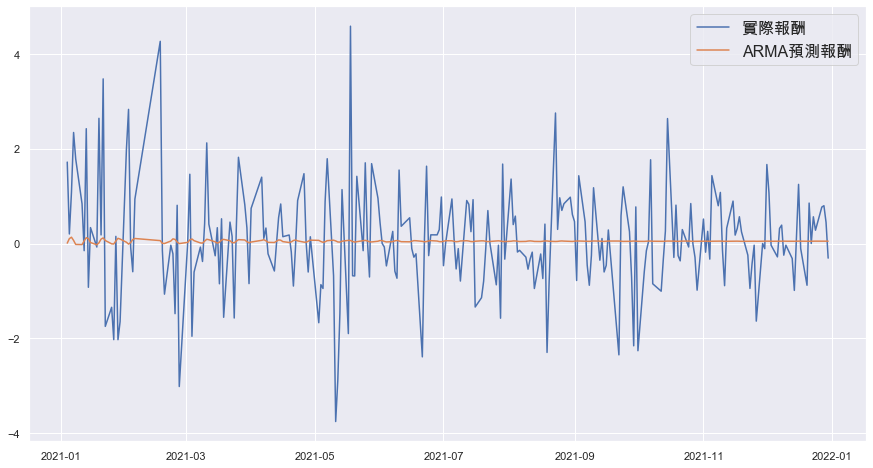

In [9]:
test_data['ARMA預測報酬(%)'] = list(forecast_mu)

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

plt.figure(figsize=(15,8))

plt.plot(test_data['日報酬率(%)'])
plt.plot(test_data['ARMA預測報酬(%)'])

plt.legend(('實際報酬', 'ARMA預測報酬'), fontsize=16)

In [10]:
garch_forecast = []

for i in range(len(test_data)):
    train = arma_resid[:-(len(test_data)-i)]
    model = arch_model(train, vol = 'GARCH', p = 1, q = 1)
    garch_fit = model.fit()
    prediction = garch_fit.forecast(horizon=1)
    garch_forecast.append(np.sqrt(prediction.variance.values[-1:][0]))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30853.594196576025
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7028.576135038324
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1608110949.2268696
Iteration:      4,   Func. Count:     28,   Neg. LLF: 179511658.82114768
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6098.965046944551
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6872.589841625309
Iteration:      7,   Func. Count:     46,   Neg. LLF: 6079.6109343952
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6301.83893805864
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6082.174003365658
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6067.706217257855
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6067.674945283197
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6067.674760783788
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6067.674754360744
Iteration:     14,   Func. Count:     83,   Neg. LLF: 6067.67475

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30863.455064531183
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7036.568825134757
Iteration:      3,   Func. Count:     22,   Neg. LLF: 219217785.44809508
Iteration:      4,   Func. Count:     28,   Neg. LLF: 364100964.8915146
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6105.102714751635
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6904.135798172963
Iteration:      7,   Func. Count:     46,   Neg. LLF: 6086.110754804299
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6250.875595953408
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6087.048667764441
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6074.025469493283
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6074.012521799942
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6074.012485520159
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6074.012483635035
Iteration:     14,   Func. Count:     83,   Neg. LLF: 6074.012

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      3,   Func. Count:     22,   Neg. LLF: 10970876.08787577
Iteration:      4,   Func. Count:     28,   Neg. LLF: 273948881.6524086
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6109.674832742865
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6908.132662810998
Iteration:      7,   Func. Count:     46,   Neg. LLF: 6090.698912481106
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6256.964767841968
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6091.649797301388
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6078.632954301507
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6078.619994636341
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6078.619958201056
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6078.6199563216505
Iteration:     14,   Func. Count:     83,   Neg. LLF: 6078.619956321688
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6078.6199563216505
            Iterations: 14

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:     14,   Func. Count:     84,   Neg. LLF: 6106.30859829826
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6106.308598299136
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6818532326.030575
Iteration:      2,   Func. Count:     15,   Neg. LLF: 585343095.7204475
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9006.297417240454
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6160.850710752387
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6134.155907046741
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6381.050544513426
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6109.123252721702
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6107.7650482399295
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6107.753996600606
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6107.754006086033

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      9,   Func. Count:     60,   Neg. LLF: 6114.476052472659
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6114.475627166114
Iteration:     11,   Func. Count:     71,   Neg. LLF: 6114.474788538124
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6114.474788544951
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6114.474788538124
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2099187692.8325686
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1373783791.084691
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9019.04041868711
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6169.555337130358
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6142.743920720762
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6394.593126797753
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6117.625877909817

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      3,   Func. Count:     23,   Neg. LLF: 9026.842178982586
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6175.530905899258
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6148.780842196224
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6409.64489750814
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6123.231927768642
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6121.660804976542
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6121.644628854201
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6121.64373849139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6121.642830900124
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6121.6428299933705
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6121.6428299933705
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 663405844.8257861

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 22685731925379.086
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4494192879.010641
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9042.595913454104
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6183.005549664977
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6156.132436787668
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6419.97197443975
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6130.412012791188
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6128.820322786163
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6128.804523186906
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6128.804097716249
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6128.803278427835
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6128.803278434733
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6128.803278427835
            Iterations: 12
 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23148039569332.16
Iteration:      2,   Func. Count:     15,   Neg. LLF: 998924717.4201434
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9059.146649500055
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6190.168132429311
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6163.138148450917
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6425.288366497629
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6137.320087240954
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6135.763498969198
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6135.749116993196
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6135.749112264688
Iteration:     11,   Func. Count:     71,   Neg. LLF: 6135.748570485898
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6135.748570486519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6135.748570485898
            Iterations: 12
 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 23259806456282.633
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4457468845.652223
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9066.36662413375
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6198.703967768657
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6172.3707972492075
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6435.161459797935
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6146.338585005161
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6144.666601293749
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6144.6487917327895
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6144.647750357164
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6144.646864313562
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6144.646863309303
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6144.64686330893
Optimization terminated successfully    (Exit mode 0)
         

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 25722832157624.17
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4207058004.0154705
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9096.701594091053
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6211.116198088242
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6185.355580523847
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6453.55914832835
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6160.312639329288
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6158.5210029767695
Iteration:      9,   Func. Count:     60,   Neg. LLF: 6158.496284100127
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6158.493818264144
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6158.492840845654
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6158.492838274047
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6158.4928382733615
Optimization terminated successfully    (Exit mode 0)
        

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 32013.492132993844
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7138.849467940216
Iteration:      3,   Func. Count:     22,   Neg. LLF: 26334169.153442804
Iteration:      4,   Func. Count:     28,   Neg. LLF: 246280627.75784978
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6219.669955286421
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7447.761526885648
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6208.786593996412
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6192.651857346609
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6184.156854738005
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6182.892768250609
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6182.887939989842
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6182.887933253938
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6182.887933254198
Optimization terminated successfully    (Exit mode 0)
       

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31693.302482157356
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7154.9301717984235
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1732518217.8619852
Iteration:      4,   Func. Count:     28,   Neg. LLF: 17523831.53076164
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6233.021001184604
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7742.238116286455
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6225.581492267411
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6204.823001637713
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6197.294259855036
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6195.964737050819
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6195.956613289495
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6195.956600902536
Iteration:     13,   Func. Count:     79,   Neg. LLF: 6195.956600902933
Optimization terminated successfully    (Exit mode 0)
       

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31535.479585533525
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7163.186770534712
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1717328024.1263676
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2790797.351117279
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6243.153822446386
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7748.145760782217
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6237.569053454366
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6214.915292662356
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6208.246900205289
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6206.152253244839
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6206.144361798848
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6206.144329640342
Iteration:     13,   Func. Count:     80,   Neg. LLF: 6206.144329142997
Optimization terminated successfully    (Exit mode 0)
        

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31362.225491048914
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7171.9228683857355
Iteration:      3,   Func. Count:     22,   Neg. LLF: 12825793.769763114
Iteration:      4,   Func. Count:     28,   Neg. LLF: 739837.035561547
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6260.358464259929
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7703.313560923026
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6252.175948445152
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6224.120193575505
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6230.527906475259
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6216.046787888237
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6216.033169163725
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6216.032873349781
Iteration:     13,   Func. Count:     80,   Neg. LLF: 6216.0328581526865
Iteration:     14,   Func. Count:     84,   Neg. LLF: 6216.03

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31429.029562810087
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7182.271015630999
Iteration:      3,   Func. Count:     22,   Neg. LLF: 16203205.303166714
Iteration:      4,   Func. Count:     28,   Neg. LLF: 942882.7697457492
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6274.993670022182
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6236.944825434667
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7865.868768075404
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6281.183270380902
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6226.504394749699
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6226.494201293084
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6226.494136920576
Iteration:     12,   Func. Count:     73,   Neg. LLF: 6226.494134458305
Iteration:     13,   Func. Count:     77,   Neg. LLF: 6226.494134458217
Optimization terminated successfully    (Exit mode 0)
        

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31342.07790168619
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7190.128639493931
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1721031385.1347768
Iteration:      4,   Func. Count:     28,   Neg. LLF: 283084.71003023867
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6305.336544254096
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6243.880152183076
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7656.520684361308
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6246.017344663961
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6235.147587935309
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6235.13732225861
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6235.137286145089
Iteration:     12,   Func. Count:     73,   Neg. LLF: 6235.137285605411
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6235.137285605411
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31278.38649504523
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7199.906140683003
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1721306723.109336
Iteration:      4,   Func. Count:     28,   Neg. LLF: 840575.4881805171
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6310.915224546713
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6254.257111754191
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7685.025194950511
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6297.3888755844455
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6245.05827550046
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6245.049074704137
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6245.048940778499
Iteration:     12,   Func. Count:     73,   Neg. LLF: 6245.048938878776
Iteration:     13,   Func. Count:     77,   Neg. LLF: 6245.048938878997
Optimization terminated successfully    (Exit mode 0)
          

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31297.849064949063
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7207.6151463404885
Iteration:      3,   Func. Count:     22,   Neg. LLF: 28786763.39490465
Iteration:      4,   Func. Count:     28,   Neg. LLF: 217873.33997886212
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6344.948254971597
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6261.318816191355
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7525.9781358828905
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6252.776117687978
Iteration:      9,   Func. Count:     57,   Neg. LLF: 6252.733474960956
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6252.7312292484
Iteration:     11,   Func. Count:     67,   Neg. LLF: 6252.730806703043
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6252.730804135044
Iteration:     13,   Func. Count:     76,   Neg. LLF: 6252.730804135849
Optimization terminated successfully    (Exit mode 0)
        

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      3,   Func. Count:     22,   Neg. LLF: 12087556.752690256
Iteration:      4,   Func. Count:     28,   Neg. LLF: 101550.94817944821
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6369.722633771737
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6268.616137201989
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7429.13790411061
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6260.702126283346
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6260.049039322539
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6260.02992317781
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6260.029922188854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6260.029922188854
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31361.158694325604
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7217.05103270518

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      3,   Func. Count:     22,   Neg. LLF: 1760132554.7750351
Iteration:      4,   Func. Count:     28,   Neg. LLF: 96862.28317948399
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6375.25945693685
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6276.3737934577075
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7430.483310023475
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6268.467538938916
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6267.688561550347
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6267.676764164584
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6267.676751554579
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6267.676751554831
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6267.676751554579
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31394.0538466222

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      2,   Func. Count:     16,   Neg. LLF: 7231.603966128631
Iteration:      3,   Func. Count:     22,   Neg. LLF: 58332327.88087236
Iteration:      4,   Func. Count:     28,   Neg. LLF: 70141.54680970692
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6383.265502006435
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6283.501589097134
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7414.5713522961905
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6275.510412843892
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6274.712099505371
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6274.703438201028
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6274.703430421727
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6274.703430422322
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6274.703430421727
            Iterations: 12
            Function evaluations: 72
            Gradient evaluations: 1

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31429.358144767895
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7239.241139452513
Iteration:      3,   Func. Count:     22,   Neg. LLF: 52749823.69723402
Iteration:      4,   Func. Count:     28,   Neg. LLF: 62232.6849214098
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6390.556937918454
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6290.264980370373
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7380.401434360076
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6282.087500187519
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6281.336635313687
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6281.329139000727
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6281.329132790674
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6281.329132791698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6281.329132790674
            Iterations: 12
 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31413.765606799057
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7248.464984526339
Iteration:      3,   Func. Count:     22,   Neg. LLF: 30160173.259079143
Iteration:      4,   Func. Count:     28,   Neg. LLF: 58916.059337183426
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6392.776488184714
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6299.575494241433
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7499.981408724258
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6291.243600712201
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6290.756370165151
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6290.748038712569
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6290.748032579906
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6290.748032580075
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6290.748032579906
            Iterations: 1

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31488.52487725112
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7255.839499469851
Iteration:      3,   Func. Count:     22,   Neg. LLF: 17567260.46744275
Iteration:      4,   Func. Count:     28,   Neg. LLF: 49062.56010867685
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6419.82596517534
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6305.356998925282
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7377.957487683852
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6297.185067718964
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6296.303473919251
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6296.2941063955805
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6296.29409722323
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6296.294097224494
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6296.29409722323
            Iterations: 12
   

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31513.79513363329
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7263.7354839692625
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1772274979.051594
Iteration:      4,   Func. Count:     28,   Neg. LLF: 46321.80328524999
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6425.379158654546
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6312.288311963815
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7388.793215072444
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6303.9742612620785
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6303.192493607936
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6303.183724596862
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6303.183716336375
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6303.183716337668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6303.183716336375
            Iterations: 12

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31576.997826717
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7271.547162371586
Iteration:      3,   Func. Count:     22,   Neg. LLF: 10139644.396969773
Iteration:      4,   Func. Count:     28,   Neg. LLF: 40674.1075478085
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6440.144897084474
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6318.953276318917
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7365.213995119504
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6310.595225294259
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6309.769530985139
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6309.759022868586
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6309.759012219358
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6309.759012221072
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6309.759012219358
            Iterations: 12
   

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31600.93013269559
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7279.5407478988745
Iteration:      3,   Func. Count:     22,   Neg. LLF: 13258595.350041393
Iteration:      4,   Func. Count:     28,   Neg. LLF: 34770.91251028289
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6445.86915802058
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6326.11846278698
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7384.970184597921
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6317.739717599972
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6316.930768803806
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6316.921180062491
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6316.921170575872
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6316.9211705774205
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6316.921170575872
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31620.799582702548
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7287.756025457862
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1771847784.6211364
Iteration:      4,   Func. Count:     28,   Neg. LLF: 25832.23773948224
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6456.346209208856
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6334.103388847511
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7409.945138738307
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6325.962091019706
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6324.901091453177
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6324.8927210419415
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6324.892712393782
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6324.8927123948515
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6324.892712393782
            Iterations: 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31181.920523279336
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7299.369751056047
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1761470472.0964828
Iteration:      4,   Func. Count:     28,   Neg. LLF: 216746.35229852845
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6389.734853940312
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7883.562153205998
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6427.555465564632
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6352.761834785925
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6343.237324401049
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6343.148694930549
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6343.148236728803
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6343.14823672569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6343.148236728803
            Iterations: 12

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31205.69986412805
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7307.864772951165
Iteration:      3,   Func. Count:     22,   Neg. LLF: 23290664.11474553
Iteration:      4,   Func. Count:     28,   Neg. LLF: 119490.0870929723
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6405.541273686014
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7798.64854577734
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6454.373084088557
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6360.66824198209
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6351.388929253257
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6351.28693688142
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6351.286256212126
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6351.286256207424
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6351.286256212126
            Iterations: 12
    

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31274.590190126226
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7315.826539856695
Iteration:      3,   Func. Count:     22,   Neg. LLF: 34224254.46937849
Iteration:      4,   Func. Count:     28,   Neg. LLF: 54861.57488956098
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6428.294565699132
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7686.342173199081
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6508.409655883445
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6367.637665712111
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6358.421790499089
Iteration:     10,   Func. Count:     65,   Neg. LLF: 6358.345952815417
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6358.345159070192
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6358.345158433116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6358.345158433116
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31252.07558880216
Iteration:      2,   Func. Count:     16,   Neg. LLF: 21915.8532173036
Iteration:      3,   Func. Count:     26,   Neg. LLF: 743544572.8677123
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6410.228493144319
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7762.6423648595855
Iteration:      6,   Func. Count:     44,   Neg. LLF: 9052.349897877426
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6408.685039532012
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6371.067327588533
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6378.324944429882
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6370.112904958423
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6370.112729761783
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6370.112729764602
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6370.112729761783
            Iterations: 12
 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:     12,   Func. Count:     78,   Neg. LLF: 6375.297950633864
Iteration:     13,   Func. Count:     82,   Neg. LLF: 6375.297950628741
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6375.297950633864
            Iterations: 13
            Function evaluations: 82
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31261.23565937623
Iteration:      2,   Func. Count:     16,   Neg. LLF: 21240.0125720521
Iteration:      3,   Func. Count:     26,   Neg. LLF: 866800321.7520174
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6417.387668314735
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7812.672717884892
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7711.6977405228245
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6415.915476786702
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6377.0784711228325
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6377.07949263516

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      3,   Func. Count:     25,   Neg. LLF: 886643776.5830841
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6423.512233877777
Iteration:      5,   Func. Count:     37,   Neg. LLF: 7865.793401152663
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6604.377925546969
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6424.683584385781
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6388.1478617541
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6383.28634952853
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6383.149249559287
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6383.149239068053
Iteration:     12,   Func. Count:     76,   Neg. LLF: 6383.14923906674
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6383.149239068053
            Iterations: 12
            Function evaluations: 76
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31324.901640571057
It

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31336.431573099067
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12205.566844452756
Iteration:      3,   Func. Count:     22,   Neg. LLF: 116131184.95879577
Iteration:      4,   Func. Count:     28,   Neg. LLF: 16932.34213841179
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1836287599.5102232
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6413.961746854302
Iteration:      7,   Func. Count:     46,   Neg. LLF: 8801.4650718956
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6403.497289284438
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6389.421231694128
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6389.508465612211
Iteration:     11,   Func. Count:     70,   Neg. LLF: 6389.404307174016
Iteration:     12,   Func. Count:     75,   Neg. LLF: 6389.404005066699
Iteration:     13,   Func. Count:     80,   Neg. LLF: 6389.404002716994
Iteration:     14,   Func. Count:     85,   Neg. LLF: 6389.404

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31371.342420564553
Iteration:      2,   Func. Count:     16,   Neg. LLF: 20337.239475336286
Iteration:      3,   Func. Count:     25,   Neg. LLF: 885304611.7948756
Iteration:      4,   Func. Count:     31,   Neg. LLF: 6437.2585588035345
Iteration:      5,   Func. Count:     37,   Neg. LLF: 7862.202847468735
Iteration:      6,   Func. Count:     43,   Neg. LLF: 6595.678668851697
Iteration:      7,   Func. Count:     49,   Neg. LLF: 6441.83210364265
Iteration:      8,   Func. Count:     55,   Neg. LLF: 6399.651801498307
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6396.536064229185
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6396.4502590547945
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6396.450247412029
Iteration:     12,   Func. Count:     76,   Neg. LLF: 6396.450247411007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6396.450247412029
            Iterations: 1

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31483.125424789774
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24962.031762997278
Iteration:      3,   Func. Count:     26,   Neg. LLF: 868973930.9393696
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6446.257371138864
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7831.20104283064
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7793.02333518432
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6445.426993184817
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6405.613804655961
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6405.623650799649
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6405.432365244707
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6405.343628816203
Iteration:     12,   Func. Count:     78,   Neg. LLF: 6405.343627101623
Iteration:     13,   Func. Count:     82,   Neg. LLF: 6405.34362709886
Optimization terminated successfully    (Exit mode 0)
           

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31446.165667302215
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24401.695764653356
Iteration:      3,   Func. Count:     26,   Neg. LLF: 889097543.4809799
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6452.856828272428
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7846.444702274265
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6698.731534584524
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6456.756910391206
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6413.947798792463
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6411.816829875424
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6411.668306902146
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6411.668301477908
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6411.66830147555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6411.668301477908
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31471.637726101137
Iteration:      2,   Func. Count:     16,   Neg. LLF: 23991.752369064587
Iteration:      3,   Func. Count:     26,   Neg. LLF: 889443912.9636638
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6459.472795197742
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7855.897392327063
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6650.11722527951
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6465.016933870799
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6421.776867904668
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6418.266885013762
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6418.165325402195
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6418.165317450901
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6418.165317449348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6418.165317450901
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31544.083835401878
Iteration:      2,   Func. Count:     16,   Neg. LLF: 23958.516193308635
Iteration:      3,   Func. Count:     26,   Neg. LLF: 664277262.2174199
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6465.805108867789
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7863.597660878718
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6637.294521239128
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6473.84142827426
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6427.657558430451
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6424.486770348962
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6424.412925924928
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6424.412914943514
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6424.412914942428
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6424.412914943514
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31576.549014825225
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7396.190539241834
Iteration:      3,   Func. Count:     22,   Neg. LLF: 20141891.229521286
Iteration:      4,   Func. Count:     28,   Neg. LLF: 69476.52935212223
Iteration:      5,   Func. Count:     34,   Neg. LLF: 6519.307135489041
Iteration:      6,   Func. Count:     40,   Neg. LLF: 6438.540359804744
Iteration:      7,   Func. Count:     46,   Neg. LLF: 7620.932960010722
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6432.773427236855
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6428.97560734632
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6428.973690031806
Iteration:     11,   Func. Count:     68,   Neg. LLF: 6428.973687605208
Iteration:     12,   Func. Count:     72,   Neg. LLF: 6428.973687605217
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6428.973687605208
            Iterations: 12


/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31571.565315907017
Iteration:      2,   Func. Count:     16,   Neg. LLF: 22692.257720353824
Iteration:      3,   Func. Count:     26,   Neg. LLF: 819235382.1069285
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6476.8769582518335
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7883.881333948446
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6670.8470631797245
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6482.31363856274
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6437.710302878556
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6435.568530878734
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6435.472605234807
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6435.472599745726
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6435.4725997437035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6435.472599745726
            Iterations: 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31666.026602605394
Iteration:      2,   Func. Count:     16,   Neg. LLF: 24636.99245086399
Iteration:      3,   Func. Count:     26,   Neg. LLF: 886441283.865451
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6483.882134167172
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7881.760099662537
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7088.909133337163
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6487.9905695424295
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6443.0872377081805
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6442.648189858896
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6442.475674412808
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6442.475664415859
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6442.475664412157
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6442.475664415859
            Iterations: 12

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31512.462586327412
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27342.452028042346
Iteration:      3,   Func. Count:     26,   Neg. LLF: 762902888.0226727
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6495.186094020689
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7884.523366779111
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11634.169827316566
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6493.668506047859
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6455.035946873219
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6454.618351765032
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6454.42391056883
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6454.423842576294
Iteration:     12,   Func. Count:     78,   Neg. LLF: 6454.423841434473
Iteration:     13,   Func. Count:     82,   Neg. LLF: 6454.423841434772
Optimization terminated successfully    (Exit mode 0)
        

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31612.014714701363
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27353.75195708181
Iteration:      3,   Func. Count:     26,   Neg. LLF: 698979835.1827304
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6501.7124841527075
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7899.29199290633
Iteration:      6,   Func. Count:     44,   Neg. LLF: 9854.943280573129
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6505.860787815067
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6460.809179444448
Iteration:      9,   Func. Count:     61,   Neg. LLF: 6460.653667677056
Iteration:     10,   Func. Count:     66,   Neg. LLF: 6460.600785868208
Iteration:     11,   Func. Count:     71,   Neg. LLF: 6460.538805134085
Iteration:     12,   Func. Count:     76,   Neg. LLF: 6460.53783196921
Iteration:     13,   Func. Count:     81,   Neg. LLF: 6460.537814939129
Iteration:     14,   Func. Count:     85,   Neg. LLF: 6460.53781

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31684.67674764743
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27371.47807322252
Iteration:      3,   Func. Count:     26,   Neg. LLF: 859374522.4668242
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6508.402483702264
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7909.09337367268
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6785.624937864146
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6516.844415173517
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6468.475449466547
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6467.13996015418
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6467.052007375365
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6467.052003427258
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6467.05200342435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6467.052003427258
            Iterations: 12
    

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31669.86768722432
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27417.84374349127
Iteration:      3,   Func. Count:     26,   Neg. LLF: 758172384.3408445
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6515.727334006047
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7916.706363350363
Iteration:      6,   Func. Count:     44,   Neg. LLF: 7100.666054445444
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6523.192705422218
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6475.219183946761
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6474.530376218722
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6474.423376771082
Iteration:     11,   Func. Count:     73,   Neg. LLF: 6474.423369750162
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6474.423369746395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6474.423369750162
            Iterations: 12
 

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31764.545841210147
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27427.785833587535
Iteration:      3,   Func. Count:     26,   Neg. LLF: 882575208.5832233
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6522.04739834816
Iteration:      5,   Func. Count:     38,   Neg. LLF: 7925.210687800368
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6661.7380800918845
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6539.163719408424
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6482.677651141188
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6480.640478841346
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6480.613295517411
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6480.61317334619
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6480.613171172943
Iteration:     13,   Func. Count:     81,   Neg. LLF: 6480.613171174358
Optimization terminated successfully    (Exit mode 0)
         

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

Iteration:      5,   Func. Count:     38,   Neg. LLF: 7938.7816854758175
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6599.413532660676
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6562.677974356542
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6497.425818688427
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6492.5275976966095
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6492.5229974196045
Iteration:     11,   Func. Count:     72,   Neg. LLF: 6492.52278051033
Iteration:     12,   Func. Count:     77,   Neg. LLF: 6492.522759964229
Iteration:     13,   Func. Count:     81,   Neg. LLF: 6492.522759966323
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6492.522759964229
            Iterations: 13
            Function evaluations: 81
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 31888.545825315483
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27471.88239896

/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set rein

In [11]:
test_data['GARCH預測波動度'] = (garch_forecast)

<ipython-input-11-016751a6e38b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['GARCH預測波動度'] = (garch_forecast)


In [12]:
test_data['預測區間上限'] = test_data['ARMA預測報酬(%)'] + test_data['GARCH預測波動度']
test_data['預測區間下限'] = test_data['ARMA預測報酬(%)'] - test_data['GARCH預測波動度']

<ipython-input-12-f2b3397fd39e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['預測區間上限'] = test_data['ARMA預測報酬(%)'] + test_data['GARCH預測波動度']
<ipython-input-12-f2b3397fd39e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['預測區間下限'] = test_data['ARMA預測報酬(%)'] - test_data['GARCH預測波動度']


In [13]:
test_data

,收盤價,日報酬率(%),ARMA預測報酬(%),GARCH預測波動度,預測區間上限,預測區間下限
年月日,,,,,,
2021-01-04,124.35,1.7178,0.007639,[0.8279701855095494],[0.8356094020683877],[-0.820330968950711]
2021-01-05,124.60,0.2010,0.103229,[0.8091855341421339],[0.9124143619831312],[-0.7059567063011366]
2021-01-06,125.95,1.0835,0.132871,[0.8441208942549913],[0.9769922034464709],[-0.7112495850635117]
2021-01-07,128.90,2.3422,0.064917,[0.8296300476106613],[0.8945467540845707],[-0.7647133411367518]
2021-01-08,131.20,1.7843,-0.019291,[0.8238660699703705],[0.8045751953491894],[-0.8431569445915515]
...,...,...,...,...,...,...
2021-12-24,143.05,0.2804,0.049718,[0.9865795261408391],[1.0362978734712274],[-0.936861178810451]
2021-12-27,144.15,0.7690,0.048563,[0.9597117572942437],[1.0082750887850893],[-0.9111484258033982]
2021-12-28,145.30,0.7978,0.047542,[0.9506302616278288],[0.9981720612572778],[-0.9030884619983799]


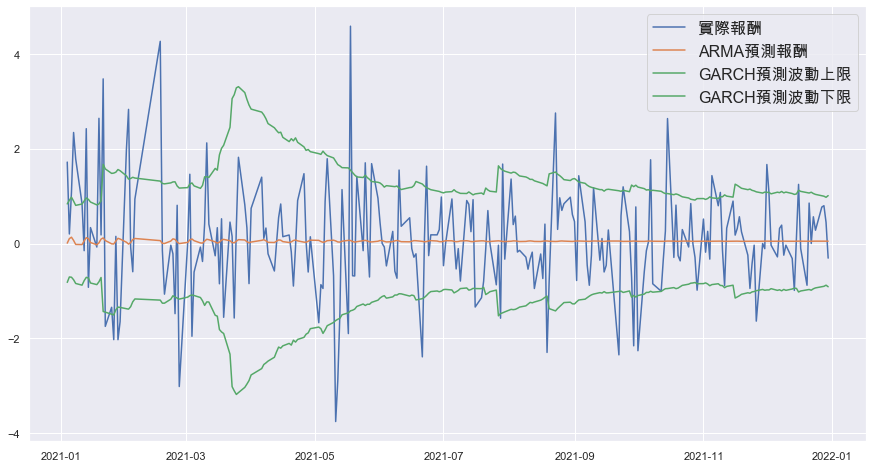

In [14]:
plt.figure(figsize=(15,8))

plt.plot(test_data['日報酬率(%)'])
plt.plot(test_data['ARMA預測報酬(%)'])
plt.plot(test_data['預測區間上限'], color = 'g')
plt.plot(test_data['預測區間下限'], color = 'g')


plt.legend(('實際報酬', 'ARMA預測報酬', 'GARCH預測波動上限', 'GARCH預測波動下限'), fontsize=16)

In [15]:
first_price = test_data['收盤價'][0] / (1+test_data['日報酬率(%)'][0]*0.01)

In [16]:
test_data['ARMA預測價格'] = first_price * (1 + test_data['ARMA預測報酬(%)']*0.01)
test_data['預測價格區間上限'] = first_price * (1 + test_data['預測區間上限']*0.01)
test_data['預測價格區間下限'] = first_price * (1 + test_data['預測區間下限']*0.01)

<ipython-input-16-aab6e2119d29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARMA預測價格'] = first_price * (1 + test_data['ARMA預測報酬(%)']*0.01)
<ipython-input-16-aab6e2119d29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['預測價格區間上限'] = first_price * (1 + test_data['預測區間上限']*0.01)
<ipython-input-16-aab6e2119d29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [17]:
for i in range(1, len(test_data)):
    test_data['ARMA預測價格'][i] = test_data['ARMA預測價格'][i-1] * (1 + test_data['ARMA預測報酬(%)'][i]*0.01)
    test_data['預測價格區間上限'][i] = test_data['預測價格區間上限'][i-1] * (1 + test_data['預測區間上限'][i]*0.01)
    test_data['預測價格區間下限'][i] = test_data['預測價格區間下限'][i-1] * (1 + test_data['預測區間下限'][i]*0.01)    

<ipython-input-17-dc5ea089bca3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARMA預測價格'][i] = test_data['ARMA預測價格'][i-1] * (1 + test_data['ARMA預測報酬(%)'][i]*0.01)
/Users/wujinru/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-17-dc5ea089bca3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [18]:
test_data['預測平均價格'] = (test_data['預測價格區間上限'] + test_data['預測價格區間下限']) / 2

<ipython-input-18-3c370926619f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['預測平均價格'] = (test_data['預測價格區間上限'] + test_data['預測價格區間下限']) / 2


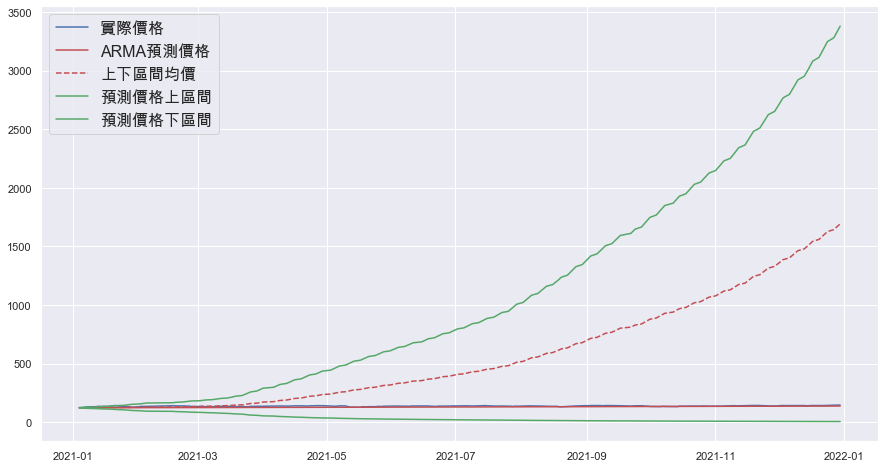

In [28]:
plt.figure(figsize=(15,8))

plt.plot(test_data['收盤價'])
plt.plot(test_data['ARMA預測價格'], color = 'r')
plt.plot(test_data['預測平均價格'], color = 'r', linestyle='dashed')
plt.plot(test_data['預測價格區間上限'], color = 'g')
plt.plot(test_data['預測價格區間下限'], color = 'g')


plt.legend(('實際價格', 'ARMA預測價格', '上下區間均價', '預測價格上區間', '預測價格下區間'), fontsize=16)

In [26]:
new_date = test_data.index.get_level_values('年月日') <= '2021-03-01'

new_test = test_data[new_date]

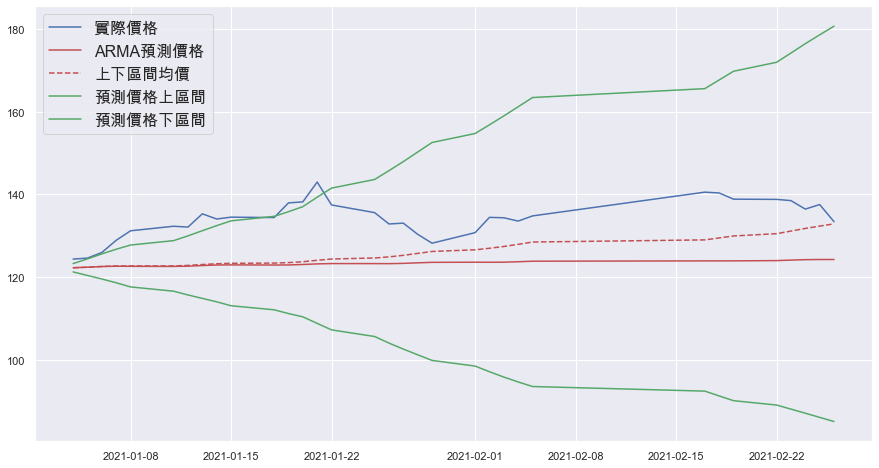

In [27]:
plt.figure(figsize=(15,8))

plt.plot(new_test['收盤價'])
plt.plot(new_test['ARMA預測價格'],color = 'r')
plt.plot(new_test['預測平均價格'], color = 'r', linestyle='dashed')
plt.plot(new_test['預測價格區間上限'], color = 'g')
plt.plot(new_test['預測價格區間下限'], color = 'g')


plt.legend(('實際價格', 'ARMA預測價格', '上下區間均價', '預測價格上區間', '預測價格下區間'), fontsize=16)